In [1]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [2]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=2     # which GPU to use
plot=True # Plot Intermediate results
sigma=5.0   # Initial model smoothness  

# Inversion parameters
num_batches = 2
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 8
dx = 10
dt = 0.001
nt = 4001
num_shots = 30
num_receivers_per_shot = 200

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [3]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
from sklearn.feature_extraction import image
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable

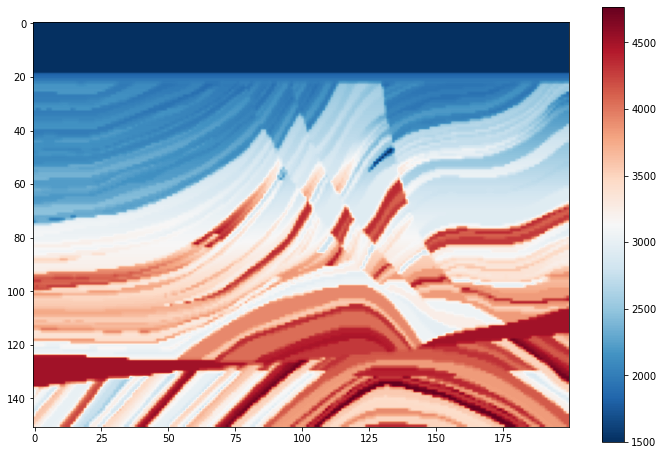

In [4]:
NX = 500;
NY = 174;
f = open("AllModels/marmousi_II_marine.vp")
data_type = np.dtype ('float32').newbyteorder ('<')
mod_true = np.fromfile (f, dtype=data_type)
mod_true = mod_true.reshape(NX,NY)
mod_true = np.transpose(mod_true)
#mod_true = np.flipud(mod_true)
plt.figure(figsize=(12,8))
fmarmousi = mod_true[:,25:475]
mat = resize(fmarmousi,(151,200))
plt.imshow(mat,'RdBu_r')
plt.colorbar()

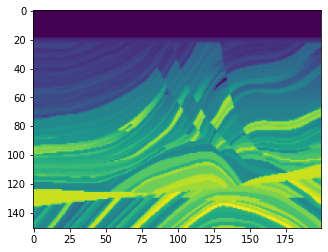

In [5]:
plt.imshow(mat)

In [6]:
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.

print('vmin=',min1,'vmax=',max1,'vmed=',med,'vwidth=',wid)

vmin= 1500.0 vmax= 4766.604 vmed= 3133.302001953125 vwidth= 1633.302001953125


In [7]:
#RB Open file to write results
f = open('marmsm_Mod8_log.txt','a+')
writer = csv.writer(f)

#RB Write header
fields=['Epoch','it','loss.item','epoch_loss','it_lap','epoch_lap']
writer.writerow(fields)
f.flush()
os.fsync(f)

In [8]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [9]:
# Set parameters
num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)

ny= 200 nz= 151 nt= 4001 dx= 10 freq= 8
shots= 30 recs/shot= 200 ds= 66.66666666666667 dr= 10.0


In [10]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.linspace(0,(ny-1)*dx,num_shots)
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [11]:
#RB Generate a cte velocy model (with water velocity)
mat2 = np.ones((nz,ny),np.float32)*1500.

mat2[nz-1,int(ny/2)]=max1  # put a pixel with true upper velocity to fix a propagator problem

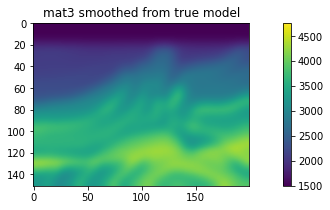

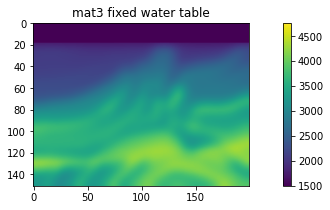

In [12]:
#RB Create a smoothed model

#RB start with true model
mat3 = np.copy(mat)
#RB Filter image heavly
mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=sigma) #10,50  #5%,10%
#for i in range(201):
#    mat3[:,i] = scipy.ndimage.gaussian_filter1d(mat3[:,i],sigma=20)
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min1,vmax=max1)
    plt.title('mat3 smoothed from true model')
    plt.colorbar()

    
#mat3 = 2200*np.ones(np.shape(mat))
#RB Force water table to be 1500 m/s (avoid imperfect direct wav removal)    
mat3[(mat==1500.0)]=1500.

#mat3[27:-1,:]=2800.
#RB Plot model
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min1,vmax=max1)
    plt.title('mat3 fixed water table')
    plt.colorbar()

#RB We may want to smooth the water table transition
#RB but I think it's a bad idea (not tested)
# mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=4)

#RB Optionally we may import a initial model from file
#filename='Marm151_401_smooth.mat'
#mat3=scipy.io.loadmat(filename)['vel0']

#RB Ensure that the initial model has the same range of the true model by
#RB forcing one of its slowest pixel to have the true's model lower velocity and
#RB forcing one of its fastest pixel to have the true's model upper velocity
#RB find max & min values of mat3
smin=np.min(mat3)
smax=np.max(mat3)
indmin = np.where(mat3==smin)
indmax = np.where(mat3==smax)
# Take first pixel with minimum velocity and force it to true's model minimum velocity
mat3[indmin[0][0],indmin[1][0]]=min1
# Take first pixel with maximum velocity and force it to true's model maximum velocity
mat3[indmax[0][0],indmax[1][0]]=max1

In [13]:
#RB Convert models to PyTorch Tensors
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor

In [14]:
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
print(np.std(seis))
#seis = seis.swapaxes(1,2)
#seis = seis.swapaxes(0,1)
#receiver_amplitudes_all = receiver_amplitudes_all.swapaxes(1,2)

0.8594362


In [15]:
#seis = seis + np.random.normal(seis,0.05*np.std(seis))

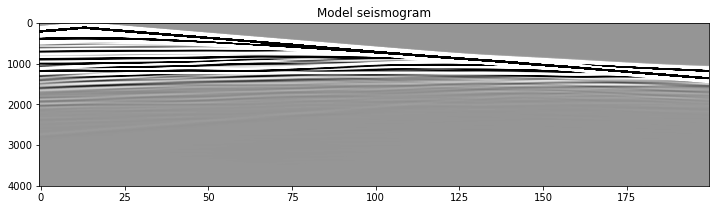

In [16]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),'Greys',vmin=-.1,vmax=.1, aspect='auto')
    
    plt.title('Model seismogram')

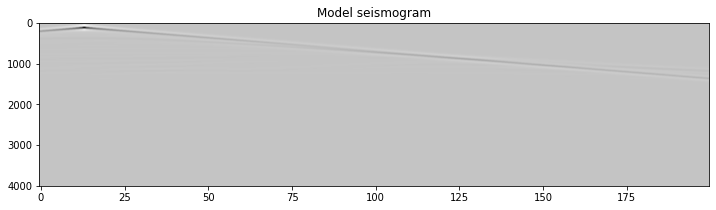

In [17]:
#with noise
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(seis[:,2],'Greys',aspect='auto')
    
    plt.title('Model seismogram')

In [18]:
# Create direct arrivals data
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

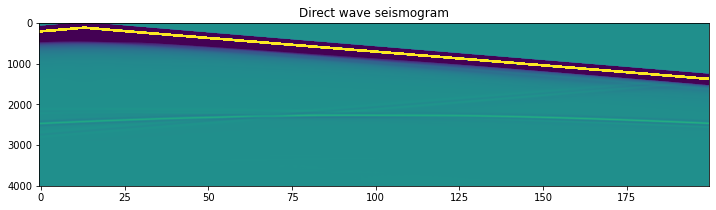

In [19]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_cte[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Direct wave seismogram')

In [20]:
# Exclude direct waves from true data (they don't bring info from subsurface)
receiver_amplitudes_true = receiver_amplitudes_all

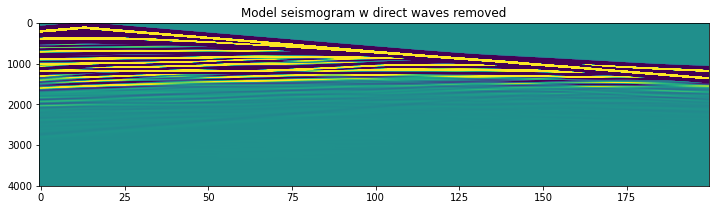

In [169]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_true[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram w direct waves removed')

In [170]:
#RB Normalize initial model to (-1,1) range
#model_init = (mat3-med)/wid
#RB_No_normalization
model_init = mat3

In [171]:
# Convert to Pytorch tensor
#model_init = torch.from_numpy(np.float32(model_init))
model_init = torch.Tensor(model_init)

# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

In [172]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/')

          
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainD')

os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testD')

0

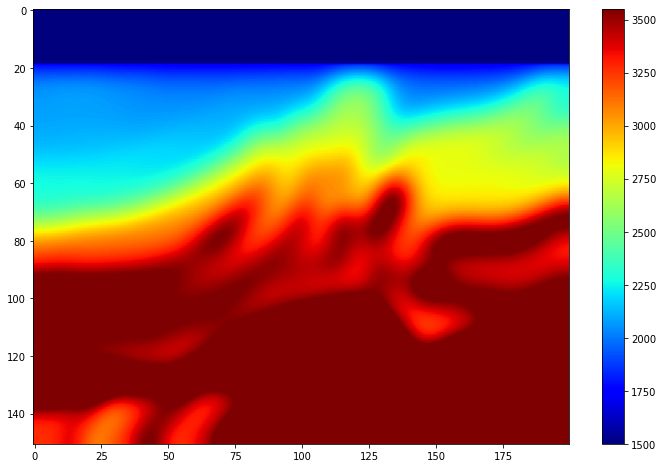

In [173]:
plt.figure(figsize=(12, 8))
plt.imshow(mat3,vmin=1500,vmax=3550,cmap='jet',aspect='auto')
plt.colorbar()

In [174]:
seis = seis.swapaxes(0,1)
#mat3 = 2200*np.ones(np.shape(mat))
#mat3[0:26,:] = 1500
A = seis
B = mat
C = mat3

for kk in range(1,2):
    
    #kk = 1
    D = torch.randn([1,8])
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/trainD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()


In [175]:
for kk in range(150,151):
    
    #kk = 1
    #D = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/ZZConstant0ep'+str(kk)+'.npy')
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/MarmousiF/testD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()

In [111]:
np.shape(seis)

(18, 4001, 200)

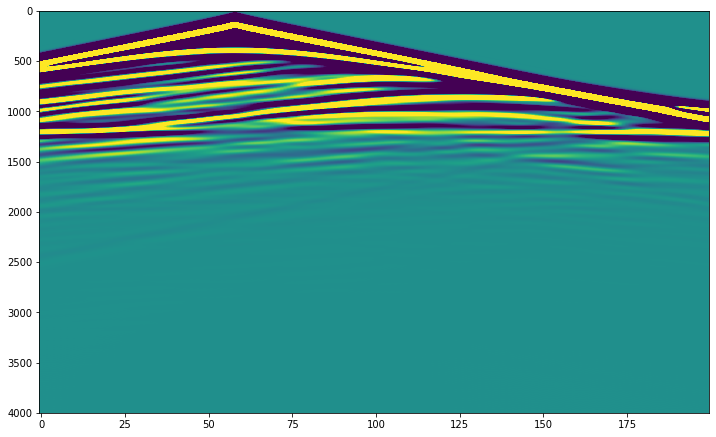

In [112]:
plt.figure(figsize=(12,8))
plt.imshow(seis[5,:,:],aspect=0.03,vmin=-0.1,vmax=0.1,)

In [63]:
np.min(mat)

1500.0

In [64]:
np.max(mat)

4766.604

<function matplotlib.pyplot.pause(interval)>

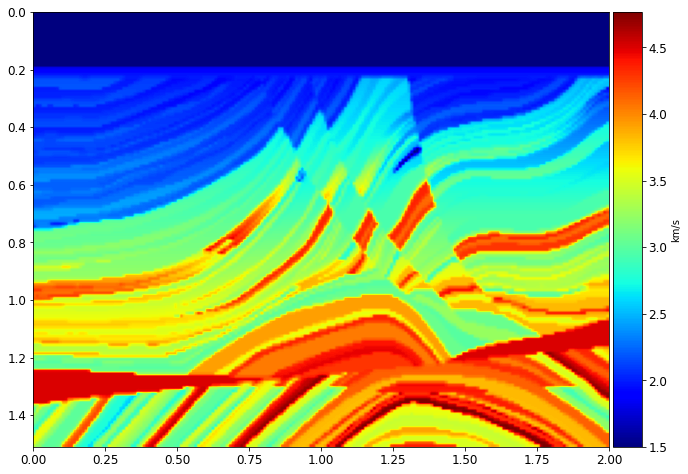

In [21]:
nx = np.shape(mat)[1]
nz = np.shape(mat)[0]
dx = 10
par = {'extent': [0, nx*dx/1000, nz*dx/1000, 0]}
plt.figure(figsize=(12,8))
im = plt.imshow(mat/1000,'jet',**par)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause

mse : 0.1481937652808424
ssim : 0.535544976706298


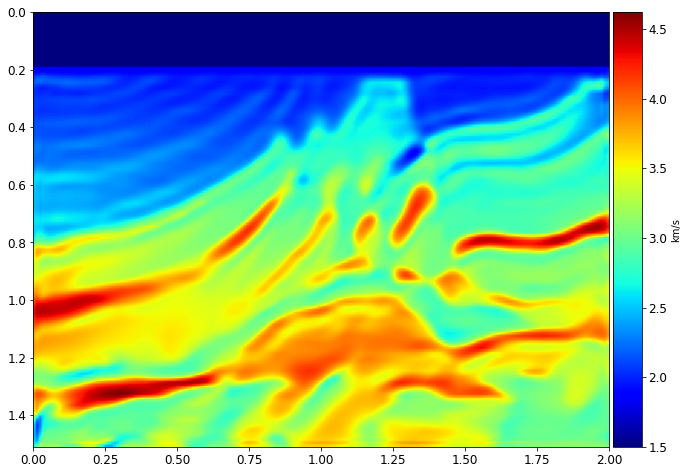

In [24]:
#cell added on 5 May
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/Fake2JanAD0ep2190.npy')
inverted = inverted[0,0,:,:]
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

mse : 0.14264464621016373
ssim : 0.561354953336131


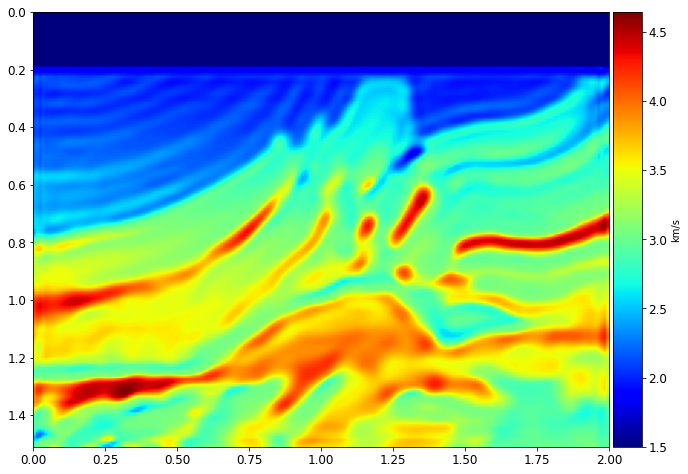

In [33]:
#cell added on 5 May
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/Fake2JanCBAMAD0ep4500.npy')
inverted = inverted[0,0,:,:]/1000
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

mse : 0.12296198036718878
ssim : 0.5808977477652096


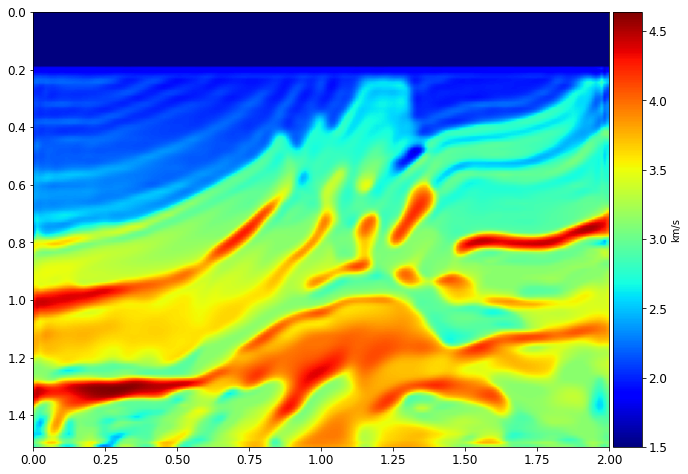

In [36]:
#cell added on 6 May
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/Fake2JanAD0ep4500.npy')
inverted = inverted[0,0,:,:]/1000
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

mse : 0.04374620954433504
ssim : 0.6914270107737952


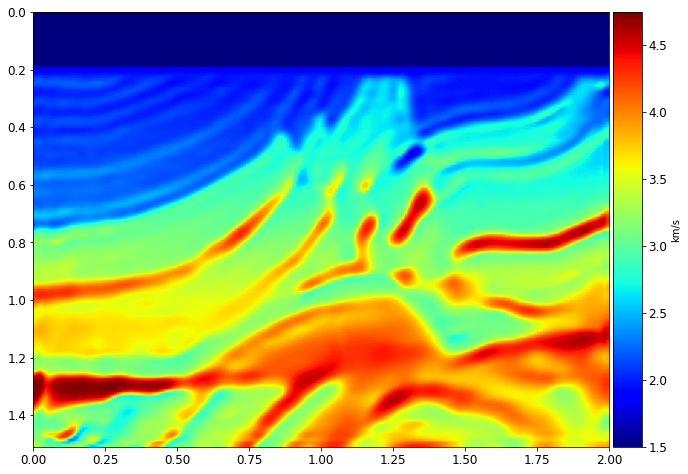

In [84]:
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeInt4AD0ep3700.npy')
inverted = inverted[0,0,:,:]
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

mse : 0.05130415036717806
ssim : 0.6635833459286704


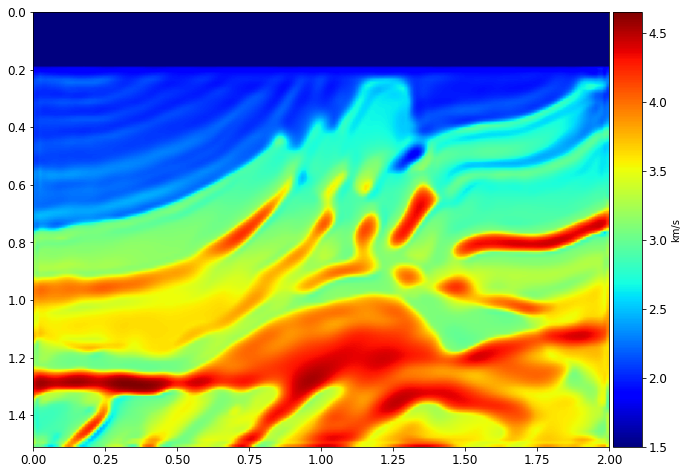

In [184]:
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeInt23DecAD0ep6000.npy')
inverted = inverted[0,0,:,:]/1000
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

mse : 0.03886636038154727
ssim : 0.6884854796612543


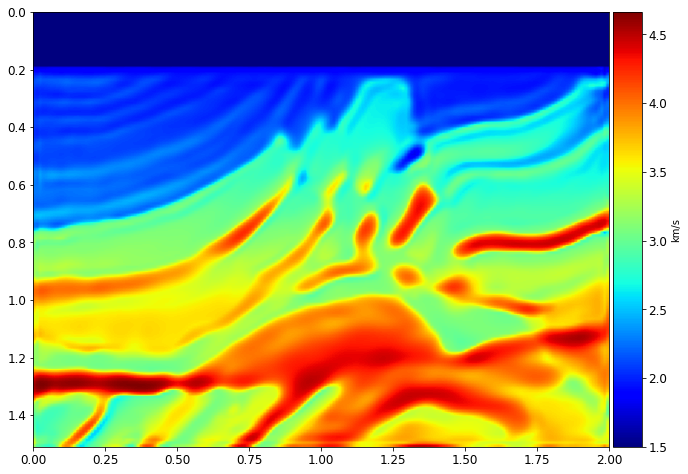

In [186]:
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeInt23Dec2AD0ep3990.npy')
inverted = inverted[0,0,:,:]/1000
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4'),
  Text(0, 1.6, '1.6')])

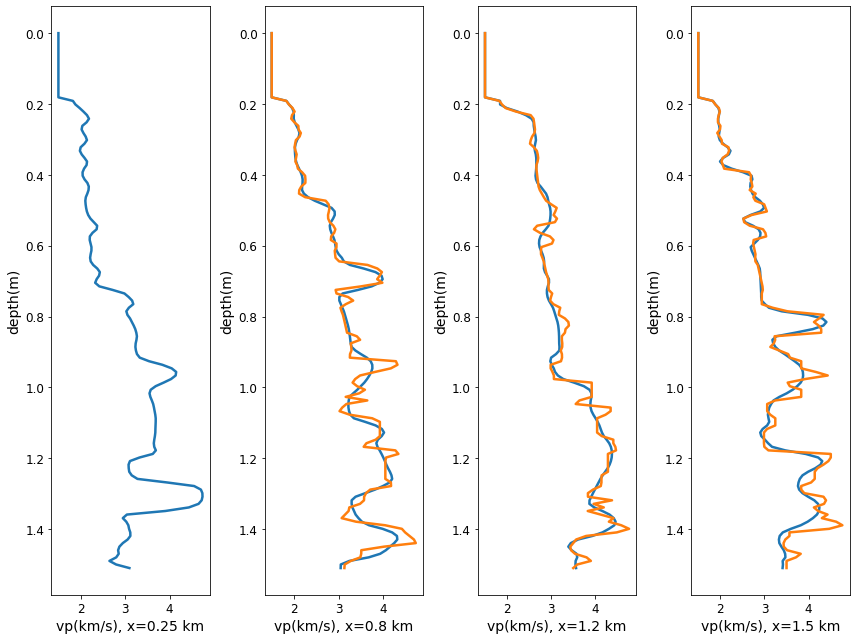

In [115]:
rows = 1
columns = 4
fig1 = plt.figure(figsize=(12,9))

ax = fig1.add_subplot(rows,columns,1)

x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(inverted[:,25],x, linewidth=2.5)
#plt.plot(mat[:,25]/1000,x, linewidth=2.5)
plt.tight_layout()
plt.xlabel('vp(km/s), x=0.25 km', fontsize=14)
plt.ylabel('depth(m)', fontsize=14)
ax = plt.gca(); ax.invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#ax.set_ylim(ymin=0)

ax = fig1.add_subplot(rows,columns,2)

x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(inverted[:,80],x, linewidth=2.5)
plt.plot(mat[:,80]/1000,x, linewidth=2.5)
plt.tight_layout()
plt.xlabel('vp(km/s), x=0.8 km', fontsize=14)
plt.ylabel('depth(m)', fontsize=14)
ax = plt.gca(); ax.invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax = fig1.add_subplot(rows,columns,3)

x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(inverted[:,120],x, linewidth=2.5)
plt.plot(mat[:,120]/1000,x, linewidth=2.5)
plt.tight_layout()
plt.xlabel('vp(km/s), x=1.2 km', fontsize=14)
plt.ylabel('depth(m)', fontsize=14)
ax = plt.gca(); ax.invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax = fig1.add_subplot(rows,columns,4)

x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(inverted[:,150],x, linewidth=2.5)
plt.plot(mat[:,150]/1000,x, linewidth=2.5)
plt.tight_layout()
plt.xlabel('vp(km/s), x=1.5 km', fontsize=14)
plt.ylabel('depth(m)', fontsize=14)
ax = plt.gca(); ax.invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


#plt.invert_yaxis()
#plt.plot(mat[:,75]/1000)

mse : 0.10541844919926896
ssim : 0.5617298056482164


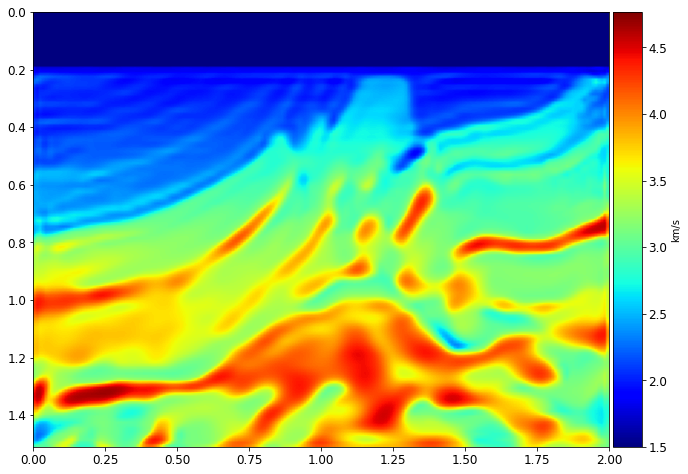

In [120]:
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/Fake20Dec2AD0ep3000.npy')
inverted = inverted[0,0,:,:]
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par, vmin=np.min(mat)/1000, vmax=np.max(mat)/1000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

mse : 0.06422245087895703
ssim : 0.6564007644281185


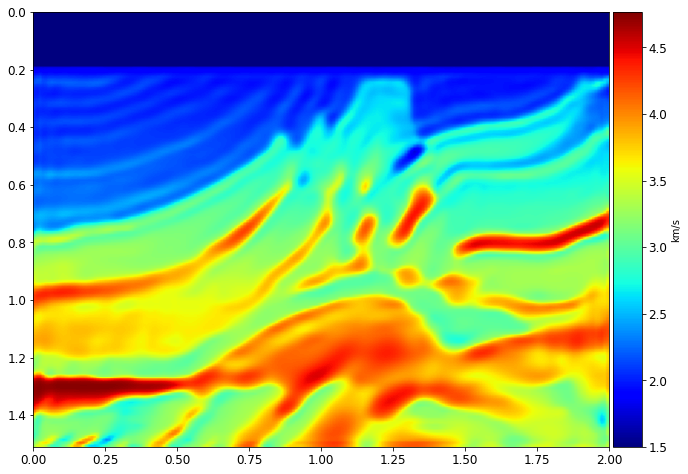

In [182]:
#Inversion using *1000 and 30 sources
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeInt22Dec2AD0ep2490.npy')
inverted = inverted[0,0,:,:]/1000
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par, vmin=np.min(mat)/1000, vmax=np.max(mat)/1000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

In [ ]:
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/Fake1s2AD0ep2100.npy')
inverted = inverted[0,0,:,:]/1000
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par, vmin=np.min(mat)/1000, vmax=np.max(mat)/1000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax, label='km/s'); cbar.ax.tick_params(labelsize=12) ;plt.pause
mse = mean_squared_error(mat/1000,inverted)
ssim = ssim(mat/1000,inverted)
print("mse :", mse)
print("ssim :", ssim)

In [86]:
np.max(mat)

4766.604

In [87]:
with open('/disk/student/adhara/Fall2021/PhysicsBasedFWI/checkpoints/marmousiconvergence/loss_log.txt') as f:
    lines = f.readlines()

In [88]:
len(lines)

4001

In [89]:
with open('/disk/student/adhara/Fall2021/PhysicsBasedFWI/checkpoints/marmousiconvergence/loss_log.txt') as f:
    lines = f.readlines()
epochs = []
mls = []
vls = []
kls = []
dls = []
for i in range(1,len(lines)):
    #print("i:",i)
    po = lines[i].split(')')
    string1 = po[0][1:]
    string2 = po[1]
    result1 = dict((a.strip(), int(b.strip()))  
                         for a, b in (element.split(':')  
                                      for element in string1.split(', ')))  
    epoch = int(result1['epoch'])
    result2 = string2.split(' ')
    modelloss = float(result2[2])
    validationloss = float(result2[6])
    klloss = float(result2[9])
    dlloss = float(result2[4])
    epochs = np.append(epochs,epoch)
    mls = np.append(mls,modelloss)
    vls = np.append(vls,validationloss)
    kls = np.append(kls,klloss)
    dls = np.append(dls,dlloss)

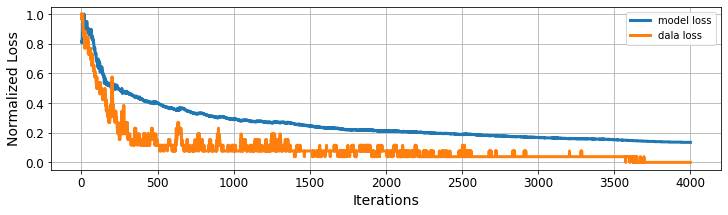

In [90]:
#plt.plot(epochs,mls)
plt.figure(figsize=(12, 3))
plt.plot(epochs,mls/np.max(mls),linewidth=3.0,label='model loss')
plt.plot(epochs,dls/np.max(dls),linewidth=3.0,label='dala loss')
#plt.ylabel("model loss : normalized error")
plt.xlabel("Iterations",fontsize=14)
plt.ylabel("Normalized Loss",fontsize=14)
plt.legend(prop={'size': 14})
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.plot(epochs,kls/np.max(kls),linewidth=3.0)
#plt.plot(epochs,vls/np.max(vls),linewidth=3.0)
plt.grid()

In [34]:
with open('/disk/student/adhara/Fall2021/PhysicsBasedFWI/checkpoints/MarmousiOpenFWI22/loss_log.txt') as f:
    lines = f.readlines()
epochs = []
mls = []
vls = []
kls = []
dls = []
for i in range(1,len(lines)):
    #print("i:",i)
    po = lines[i].split(')')
    string1 = po[0][1:]
    string2 = po[1]
    result1 = dict((a.strip(), int(b.strip()))  
                         for a, b in (element.split(':')  
                                      for element in string1.split(', ')))  
    epoch = int(result1['epoch'])
    result2 = string2.split(' ')
    modelloss = float(result2[2])
    validationloss = float(result2[6])
    klloss = float(result2[9])
    dlloss = float(result2[4])
    epochs = np.append(epochs,epoch)
    mls = np.append(mls,modelloss)
    vls = np.append(vls,validationloss)
    kls = np.append(kls,klloss)
    dls = np.append(dls,dlloss)

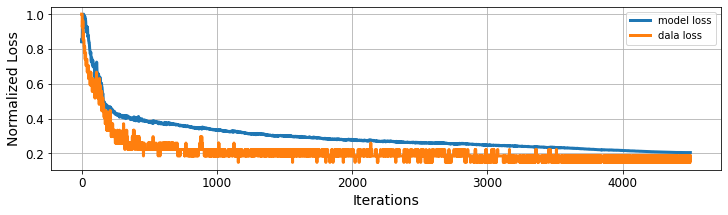

In [35]:
#plt.plot(epochs,mls)
plt.figure(figsize=(12, 3))
plt.plot(epochs,mls/np.max(mls),linewidth=3.0,label='model loss')
plt.plot(epochs,dls/np.max(dls),linewidth=3.0,label='dala loss')
#plt.ylabel("model loss : normalized error")
plt.xlabel("Iterations",fontsize=14)
plt.ylabel("Normalized Loss",fontsize=14)
plt.legend(prop={'size': 14})
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.plot(epochs,kls/np.max(kls),linewidth=3.0)
#plt.plot(epochs,vls/np.max(vls),linewidth=3.0)
plt.grid()

In [91]:
np.max(mat/1000)

4.766604

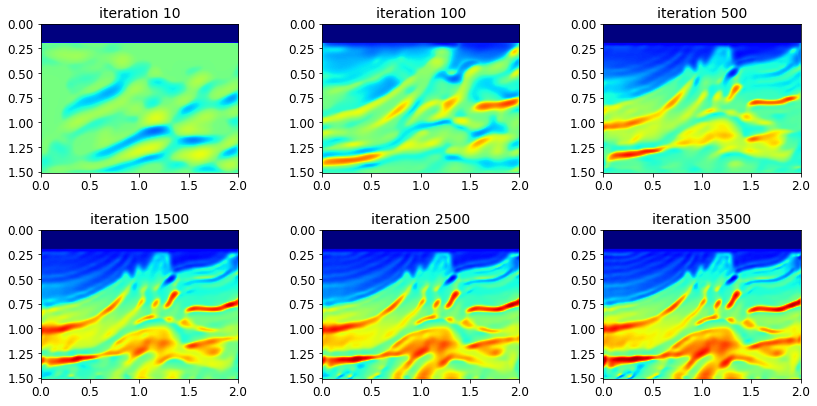

In [114]:
rows = 2
columns = 3
fig1 = plt.figure(figsize=(12,6))

#plt.subplots_adjust(left=0.05, right=0.95, top=0.1)
max1 = np.max(mat/1000)
min1 = np.min(mat/1000)

ax = fig1.add_subplot(rows,columns,1)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeIntAD0ep10.npy')
im1 = im1[0,0,:,:]
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 10",fontsize=14)


ax = fig1.add_subplot(rows,columns,2)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeIntAD0ep100.npy')
im1 = im1[0,0,:,:]
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 100",fontsize=14)

ax = fig1.add_subplot(rows,columns,3)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeIntAD0ep500.npy')
im1 = im1[0,0,:,:]
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 500",fontsize=14)

ax = fig1.add_subplot(rows,columns,4)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeIntAD0ep1500.npy')
im1 = im1[0,0,:,:]
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 1500",fontsize=14)

#ax = fig1.add_subplot(rows,columns,5)
#im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeAD0ep2500.npy')
#im1 = np.squeeze(np.squeeze(im1/1000))
#im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
#ax = plt.gca(); 
#ax.set_title("iteration 2500")

ax = fig1.add_subplot(rows,columns,5)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeIntAD0ep2500.npy')
im1 = im1[0,0,:,:]
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 2500",fontsize=14)

ax = fig1.add_subplot(rows,columns,6)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeIntAD0ep3500.npy')
im1 = im1[0,0,:,:]
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title("iteration 3500",fontsize=14)

#ax = fig1.add_subplot(rows,columns,7)
#im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeNADR20ep1600.npy')
#im1 = np.squeeze(np.squeeze(im1/1000))
#im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
#ax = plt.gca(); 
#ax.set_title("iteration 4600")

#ax = fig1.add_subplot(rows,columns,7)
#im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeNADR30ep800.npy')
#im1 = np.squeeze(np.squeeze(im1/1000))
#im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
#ax = plt.gca(); 
#ax.set_title("iteration 5800")

#ax = fig1.add_subplot(rows,columns,8)
#im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeNADR30ep1200.npy')
#im1 = np.squeeze(np.squeeze(im1/1000))
#im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
#ax = plt.gca(); 
#ax.set_title("iteration 6200")

#ax = fig1.add_subplot(rows,columns,9)
#im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeNADR30ep1900.npy')
#im1 = np.squeeze(np.squeeze(im1/1000))
#im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
#ax = plt.gca(); 
#ax.set_title("iteration 6900")

fig1.tight_layout(pad=2.0)

Text(0.5, 1.0, 'iteration 10')

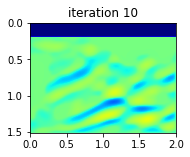

In [96]:
fig1 = plt.figure(figsize=(12,9))

#plt.subplots_adjust(left=0.05, right=0.95, top=0.1)
max1 = np.max(mat/1000)
min1 = np.min(mat/1000)

ax = fig1.add_subplot(rows,columns,1)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi24/FakeIntAD0ep10.npy')
im1 = im1[0,0,:,:]
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 10")

In [34]:
def plotFakeVelNewStd():
    
    #create figure
    #fig1 = plt.figure(figsize=(9,9))
    #fig2 = plt.figure(figsize=(15,15))
    
    rows = 3
    columns = 3
    matVel = np.zeros((35,1,151,200))
    for k in range(35):
        filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Output'+str(k)+'/'    
        for i in range(1):
            #fig.add_subplot(rows,columns,i+1)
            #kk=starting+i
            onefile = filename+'150_fake_BT.npy'
            mat=np.load(onefile)
            mat = mat/1000
            matVel[k,i,:,:] = mat
            
    mean = np.mean(matVel,axis=0)
    std = np.std(matVel,axis=0)
    p1 = np.percentile(matVel,5,axis=0)
    q1 = np.percentile(matVel,95,axis=0)
    mean = np.squeeze(mean)
    std = np.squeeze(std)
    p1 = np.squeeze(p1)
    q1 = np.squeeze(q1)
    
    print("mean :", np.shape(mean))
    print("std :", np.shape(std))
    print("p1 :", np.shape(p1))
    print("q1 :", np.shape(q1))
    return mean, std, p1, q1

In [35]:
mean,std,p1,q1 = plotFakeVelNewStd()

mean : (151, 200)
std : (151, 200)
p1 : (151, 200)
q1 : (151, 200)


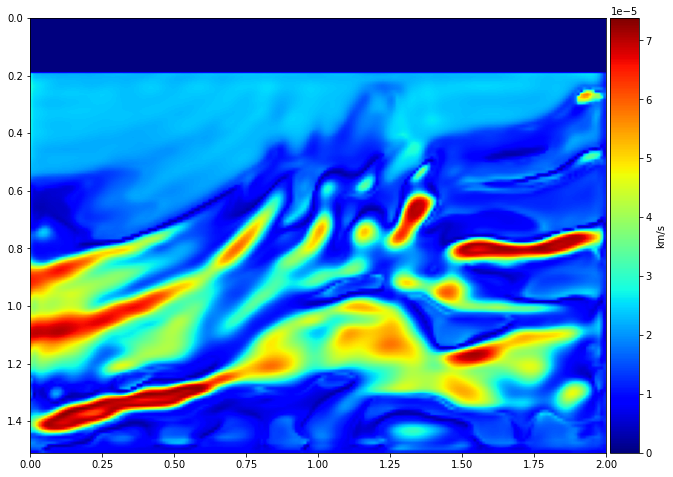

In [36]:
par = {'extent': [0, nx*dx/1000, nz*dx/1000, 0]}
plt.figure(figsize=(12,8))
im = plt.imshow(std,'jet',**par)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); plt.colorbar(im, cax=cax, label='km/s'); 

<function matplotlib.pyplot.pause(interval)>

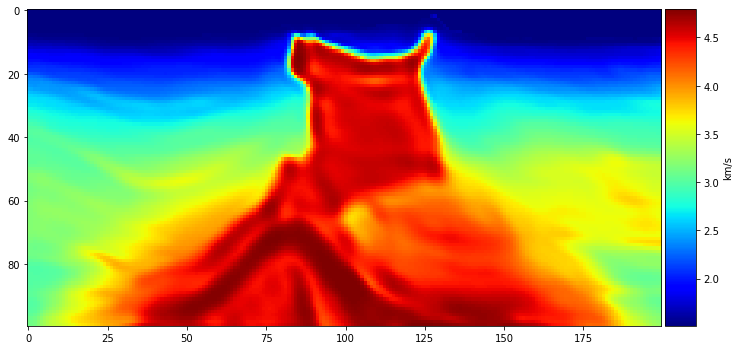

In [115]:
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi23/FakeAD0ep3000.npy')
inverted = inverted[0,0,:,:]
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet')
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); plt.colorbar(im, cax=cax, label='km/s'); plt.pause

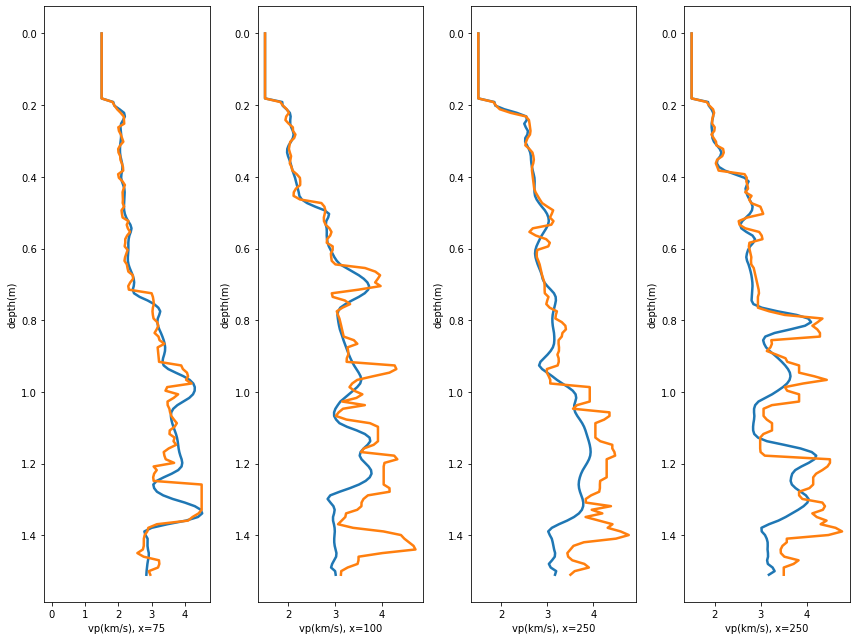

In [69]:
rows = 1
columns = 4
fig1 = plt.figure(figsize=(12,9))

ax = fig1.add_subplot(rows,columns,1)

x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(mean[:,25],x, linewidth=2.5)
plt.plot(mat[:,25]/1000,x, linewidth=2.5)
#plt.plot(p1[:,25],x, linewidth=2.5)
#plt.plot(q1[:,25],x, linewidth=2.5)
#plt.fill_between(x,np.expand_dims(p1[:,25],1),np.expand_dims(q1[:25],1))
pp = p1[:,25]/1000
qq = q1[:,25]/1000
plt.fill_betweenx(x,pp,qq)
plt.tight_layout()
plt.xlabel('vp(km/s), x=75')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()
#ax.set_ylim(ymin=0)

ax = fig1.add_subplot(rows,columns,2)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(mean[:,80],x, linewidth=2.5)
plt.plot(mat[:,80]/1000,x, linewidth=2.5)
#plt.plot(p1[:,80],x, linewidth=2.5)
#plt.plot(q1[:,80],x, linewidth=2.5)
pp = p1[:,80]
qq = q1[:,80]
plt.fill_betweenx(x,pp,qq,alpha=0.4)
plt.tight_layout()
plt.xlabel('vp(km/s), x=100')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()

ax = fig1.add_subplot(rows,columns,3)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(mean[:,120],x, linewidth=2.5)
plt.plot(mat[:,120]/1000,x, linewidth=2.5)
pp = p1[:,120]
qq = q1[:,120]
plt.fill_betweenx(x,pp,qq,alpha=0.4)
plt.tight_layout()
plt.xlabel('vp(km/s), x=250')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()

ax = fig1.add_subplot(rows,columns,4)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(mean[:,150],x, linewidth=2.5)
plt.plot(mat[:,150]/1000,x, linewidth=2.5)
pp = p1[:,150]
qq = q1[:,150]
plt.fill_betweenx(x,pp,qq,alpha=0.4)
plt.tight_layout()
plt.xlabel('vp(km/s), x=250')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()

In [ ]:
pp = p1[:,25]
qq = q1[:,25]
plt.fill_betweenx(x,pp,qq)

In [ ]:
rows = 5
columns = 3
fig1 = plt.figure(figsize=(15,12))

ax = fig1.add_subplot(rows,columns,1)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Down3IntAD0ep20.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet',aspect=0.15)
old = im1
plt.colorbar()
ax.set_title("Iteration 20")

ax = fig1.add_subplot(rows,columns,4)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Down3IntAD0ep100.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet',aspect=0.15)
new = im1
plt.colorbar()
ax.set_title("Iteration 100")

ax = fig1.add_subplot(rows,columns,7)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Down3IntAD0ep500.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet',aspect=0.15)
new = im1
plt.colorbar()
ax.set_title("Iteration 500")

ax = fig1.add_subplot(rows,columns,10)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Down3IntAD0ep1000.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet',aspect=0.15)
new = im1
plt.colorbar()
ax.set_title("Iteration 1000")

ax = fig1.add_subplot(rows,columns,13)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Down3IntAD0ep2000.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet',aspect=0.15)
new = im1
plt.colorbar()
ax.set_title("Iteration 2000")

fig1.tight_layout(pad=2.0)

#im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up2IntAD0ep60.npy')
#im1 = np.squeeze(im1)
#im1 = im1[20,:,:]
#im = plt.imshow(im1,'jet')
#ax = plt.gca(); 

In [ ]:
rows = 5
columns = 3
fig1 = plt.figure(figsize=(15,12))

ax = fig1.add_subplot(rows,columns,1)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up2IntAD0ep20.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet')
old = im1
plt.colorbar()
ax.set_title("Iteration 20")

ax = fig1.add_subplot(rows,columns,4)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up2IntAD0ep100.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet')
new = im1
plt.colorbar()
ax.set_title("Iteration 100")

ax = fig1.add_subplot(rows,columns,7)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up2IntAD0ep500.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet')
new = im1
plt.colorbar()
ax.set_title("Iteration 500")

ax = fig1.add_subplot(rows,columns,10)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up2IntAD0ep1000.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet')
new = im1
plt.colorbar()
ax.set_title("Iteration 1000")

ax = fig1.add_subplot(rows,columns,13)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up2IntAD0ep2000.npy')
im1 = np.squeeze(im1)
im1 = im1[20,:,:]
im = plt.imshow(im1,'jet')
new = im1
plt.colorbar()
ax.set_title("Iteration 2000")
#ax = plt.gca(); 
#ax.set_title("iteration 10")
fig1.tight_layout(pad=2.0)

In [ ]:
rows = 5
columns = 3
fig1 = plt.figure(figsize=(15,12))

ax = fig1.add_subplot(rows,columns,1)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up1IntAD0ep20.npy')
im1 = np.squeeze(im1)
im1 = im1[8,:,:]
im = plt.imshow(im1,'jet')
old = im1
plt.colorbar()
ax.set_title("Iteration 20")

ax = fig1.add_subplot(rows,columns,4)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up1IntAD0ep100.npy')
im1 = np.squeeze(im1)
im1 = im1[8,:,:]
im = plt.imshow(im1,'jet')
new = im1
plt.colorbar()
ax.set_title("Iteration 100")

ax = fig1.add_subplot(rows,columns,7)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up1IntAD0ep500.npy')
im1 = np.squeeze(im1)
im1 = im1[8,:,:]
im = plt.imshow(im1,'jet')
new = im1
plt.colorbar()
ax.set_title("Iteration 500")

ax = fig1.add_subplot(rows,columns,10)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up1IntAD0ep1000.npy')
im1 = np.squeeze(im1)
im1 = im1[8,:,:]
im = plt.imshow(im1,'jet')
new = im1
plt.colorbar()
ax.set_title("Iteration 1000")

ax = fig1.add_subplot(rows,columns,13)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/Up1IntAD0ep2000.npy')
im1 = np.squeeze(im1)
im1 = im1[8,:,:]
im = plt.imshow(im1,'jet')
new = im1
plt.colorbar()
ax.set_title("Iteration 2000")
fig1.tight_layout(pad=2.0)

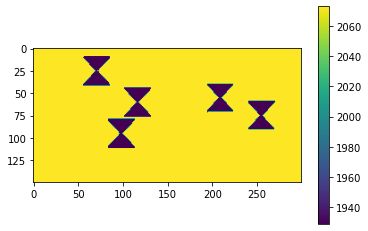

In [33]:
vp = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousiEl/rhoo.npy')
plt.imshow(vp)
plt.colorbar()